### Spring 2025 ECG Analysis 

##### Modification: switched from rapidHRV to Systole for heart rate preprocessing & peak detection

In [1]:
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame as DF

import seaborn as sns
sns.set(color_codes=True)
#np.random.seed(sum(map(ord, "distributions")))
from sklearn import linear_model  # packages for the logistic regression function to plot the logistic regression 
from sklearn.linear_model import LogisticRegression # packages for the logistic regression function to plot the logistic regression 
import scipy
from scipy import stats, integrate
from scipy.stats import mode
from scipy.stats.stats import pearsonr # Pearson's correlation
from scipy.stats import sem
from copy import copy as copy
import operator as operator

import pylab

# Plotting tools
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%pylab inline
figsize(5, 5)

import glob

from scipy.signal import find_peaks

from scipy.signal import butter, filtfilt, find_peaks

import os
# Added to avoid OMP:error#15
os.environ['KMP_DUPLICATE_LIB_OK']='True'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/var/folders/fk/gj43ql8172g1p_322ps4bc440000gn/T/ipykernel_34675/1149338489.py:13: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr # Pearson's correlation
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/magics/pylab.py:166: UserWarning: pylab import has clobbered these variables: ['pylab', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
import pathlib
from ecgdetectors import Detectors
import sys
sampleRate = 100
fs = sampleRate
detectors = Detectors(sampleRate)


In [3]:
mergedDFClean = pd.read_csv("mergedPhysioAndBehav_Jan2025.csv")
# remove Unamed columns
mergedDFClean = mergedDFClean.loc[:, ~mergedDFClean.columns.str.contains('^Unnamed')]
mergedDFClean = mergedDFClean.dropna()

In [7]:
first10 = mergedDFClean.head(50)

# save to a new CSV
first10.to_csv("mergedPhysioAndBehav_first50.csv", index=False)

In [4]:
mergedDFClean

,PART_x,EKG,EDA,startBlock,startTrial,infoChoice,stimInfo,stimNoInfo,scream,noScream,...,delaysRaw,session,partNum,PART_y,delay_time,choice_keys,prob,screamOn,infoOn,filename
0,P044_Aversive,-0.126495,3.59192,0,1,0,0,0,0,0,...,20.01,0,44,AV_P044,20.0,j,5.0,0.0,1.0,AV_P044_timeline_Blocks_macVer_2023-11-17_14h3...
1,P044_Aversive,-0.215912,3.59039,0,1,0,0,0,0,0,...,20.01,0,44,AV_P044,20.0,j,5.0,0.0,1.0,AV_P044_timeline_Blocks_macVer_2023-11-17_14h3...
2,P044_Aversive,-0.307312,3.59192,0,1,0,0,0,0,0,...,20.01,0,44,AV_P044,20.0,j,5.0,0.0,1.0,AV_P044_timeline_Blocks_macVer_2023-11-17_14h3...
3,P044_Aversive,-0.311432,3.59039,0,1,0,0,0,0,0,...,20.01,0,44,AV_P044,20.0,j,5.0,0.0,1.0,AV_P044_timeline_Blocks_macVer_2023-11-17_14h3...
4,P044_Aversive,-0.287170,3.59192,0,1,0,0,0,0,0,...,20.01,0,44,AV_P044,20.0,j,5.0,0.0,1.0,AV_P044_timeline_Blocks_macVer_2023-11-17_14h3...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12708414,P132_Aversive,-0.005310,4.98199,0,0,0,0,0,0,0,...,9.97,5,132,AV_P132,10.0,j,4.0,1.0,0.0,AV_P132_timeline_Blocks_randKeyCue_macVer_2025...
12708415,P132_Aversive,-0.020203,4.98810,0,0,0,0,0,0,0,...,9.97,5,132,AV_P132,10.0,j,4.0,1.0,0.0,AV_P132_timeline_Blocks_randKeyCue_macVer_2025...
12708416,P132_Aversive,-0.015320,4.98352,0,0,0,0,0,0,0,...,9.97,5,132,AV_P132,10.0,j,4.0,1.0,0.0,AV_P132_timeline_Blocks_randKeyCue_macVer_2025...
12708417,P132_Aversive,-0.010315,4.98199,0,0,0,0,0,0,0,...,9.97,5,132,AV_P132,10.0,j,4.0,1.0,0.0,AV_P132_timeline_Blocks_randKeyCue_macVer_2025...


In [5]:
mergedDFClean.columns

Index(['PART_x', 'EKG', 'EDA', 'startBlock', 'startTrial', 'infoChoice',
       'stimInfo', 'stimNoInfo', 'scream', 'noScream', 'endTrial',
       'startTrialOnset', 'screamOnset', 'noScreamOnset', 'infoChoiceOnset',
       'stimInfoOnset', 'stimNoInfoOnset', 'startBlockOnset', 'timePart',
       'time', 'trials', 'zEDA', 'delays', 'delaysRaw', 'session', 'partNum',
       'PART_y', 'delay_time', 'choice_keys', 'prob', 'screamOn', 'infoOn',
       'filename'],
      dtype='object')

In [77]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks
import matplotlib.pyplot as plt
import seaborn as sns

# ————— Utility: Bandpass filter and peak detection —————
def preprocess_all(df, sfreq=1000):
    b, a = butter(2, [5/(sfreq/2), 25/(sfreq/2)], btype='band')
    parts = []
    for part in df['partNum'].unique():
        sub = df[df['partNum']==part].copy()
        raw  = sub['EKG'].values
        time = sub['time'].values
        filt = filtfilt(b, a, raw)
        idxs, _ = find_peaks(filt, distance=int(0.4*sfreq), prominence=0.3)
        mask = np.zeros_like(filt, dtype=bool)
        mask[idxs] = True
        sub['pEKG']      = filt
        sub['peak']      = mask
        sub['peak_time'] = np.where(mask, time, np.nan)
        parts.append(sub)
    return pd.concat(parts, ignore_index=True)


In [87]:
def build_beats_df(df):
    """
    From the preprocessed DataFrame, keep only rows where a peak was detected,
    compute interbeat interval (IBI), and extract info/stimulus onset times and flags.
    """
    peaks = df.dropna(subset=['peak_time']).copy()
    peaks['ibi'] = peaks.groupby(['partNum', 'session', 'trials'])['peak_time'].diff()

    
    return peaks

In [88]:
# ————— Compute baseline IBI per trial using first trial —————

def compute_baseline(peaks):
    """
    Baseline IBI is the average IBI in the pre_window before info cue,
    only for trials where trials == 1.
    """
    baseline = (
        peaks
        .groupby(['partNum', 'session', 'trials'])['ibi']
        .mean()
        .reset_index(name='baseline')
    )
    return baseline

In [89]:


# ————— Compute mean IBI in extended window around cues —————
def compute_interval_ibi(peaks_df, baseline_df, pre_window=2.0, post_window=2.0):
    """
    For each trial, average IBI in [infoOnset-pre_window, stimOnset+post_window]
    then subtract baseline. Returns DataFrame with columns:
    ['delay','stimInfo','stimNoInfo','scream','noScream','mean_ibi','norm_ibi'].
    """
    records = []
    group_cols = ['partNum','session','trials','delay',
                  'stimInfoOnset','stimNoInfoOnset','screamOnset','noScreamOnset']
    for key, grp in peaks_df.groupby(group_cols):
        part, session, trial, delay, info_flag, noinfo_flag, scream_flag, noscream_flag = key
        info_on = grp['infoOnset'].iloc[0]
        stim_on = grp['stimOnset'].iloc[0]
        start   = info_on - pre_window
        end     = stim_on + post_window
        mask    = (grp['peak_time']>=start) & (grp['peak_time']<=end)
        mean_ibi = grp.loc[mask, 'ibi'].mean()
        base_row = baseline_df[(baseline_df['partNum']==part) &
                               (baseline_df['session']==session)]
        base      = base_row['baseline'].iloc[0] if not base_row.empty else np.nan
        norm_ibi  = mean_ibi - base
        records.append({
            'delay': delay,
            'stimInfo': info_flag,
            'stimNoInfo': noinfo_flag,
            'scream': scream_flag,
            'noScream': noscream_flag,
            'mean_ibi': mean_ibi,
            'norm_ibi': norm_ibi
        })
    return pd.DataFrame(records)

In [90]:

# ————— Plot condition comparisons for each delay —————
def plot_conditions_by_delay(interval_df):
    sns.set_style('whitegrid')
    for d in sorted(interval_df['delay'].dropna().unique()):
        df_d = interval_df[interval_df['delay']==d]
        fig, axes = plt.subplots(2, 2, figsize=(12,8))
        # 1) NoInfo vs Info
        df1 = df_d.groupby('stimInfo')['norm_ibi'].mean().reindex([0,1]).reset_index()
        axes[0,0].bar(['NoInfo','Info'], df1['norm_ibi'], color=['gray','skyblue'])
        axes[0,0].set_title('NoInfo vs Info')
        axes[0,0].set_ylabel('ΔIBI (s)')
        # 2) NoStim vs Stim
        df2 = df_d.groupby('screamOn')['norm_ibi'].mean().reindex([0,1]).reset_index()
        axes[0,1].bar(['NoStim','Stim'], df2['norm_ibi'], color=['gray','coral'])
        axes[0,1].set_title('NoStim vs Stim')
        # 3) Info: NoStim vs Stim
        df3 = df_d[df_d['stimInfo']==1].groupby('screamOn')['norm_ibi'].mean().reindex([0,1]).reset_index()
        axes[1,0].bar(['NoStim','Stim'], df3['norm_ibi'], color=['lightgray','blue'])
        axes[1,0].set_title('Info: NoStim vs Stim')
        axes[1,0].set_ylabel('ΔIBI (s)')
        # 4) NoInfo: NoStim vs Stim
        df4 = df_d[df_d['stimInfo']==0].groupby('screamOn')['norm_ibi'].mean().reindex([0,1]).reset_index()
        axes[1,1].bar(['NoStim','Stim'], df4['norm_ibi'], color=['lightgray','red'])
        axes[1,1].set_title('NoInfo: NoStim vs Stim')
        plt.suptitle(f'Delay = {d} s')
        plt.tight_layout(rect=[0,0.03,1,0.95])
        plt.show()

In [91]:

# === Full usage pipeline ===
df_clean     = preprocess_all(mergedDFClean)


In [92]:
beats        = build_beats_df(df_clean)

In [93]:
beats

,PART_x,EKG,EDA,startBlock,startTrial,infoChoice,stimInfo,stimNoInfo,scream,noScream,...,screamOn,infoOn,filename,pEKG,peak,peak_time,ibi,infoOnset,stimOnset,delay
0,P044_Aversive,0.628052,3.56598,0,0,1,0,0,0,0,...,0.0,1.0,AV_P044_timeline_Blocks_macVer_2023-11-17_14h3...,0.274848,True,566.71,NaN,568.14,NaN,20.0
1,P044_Aversive,0.716248,3.50647,0,0,0,1,0,0,0,...,0.0,1.0,AV_P044_timeline_Blocks_macVer_2023-11-17_14h3...,0.295240,True,572.25,5.54,568.14,NaN,20.0
2,P044_Aversive,0.585785,3.47137,0,0,0,1,0,0,0,...,0.0,1.0,AV_P044_timeline_Blocks_macVer_2023-11-17_14h3...,0.265774,True,577.75,5.50,568.14,NaN,20.0
3,P044_Aversive,0.643921,3.43475,0,0,0,1,0,0,0,...,0.0,1.0,AV_P044_timeline_Blocks_macVer_2023-11-17_14h3...,0.216458,True,581.86,4.11,568.14,NaN,20.0
4,P044_Aversive,0.758057,3.38287,0,0,0,1,0,0,0,...,0.0,1.0,AV_P044_timeline_Blocks_macVer_2023-11-17_14h3...,0.309010,True,586.08,4.22,568.14,NaN,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11019,P131_Aversive,0.659485,9.90143,0,0,0,0,0,0,0,...,0.0,0.0,AV_P131_timeline_Blocks_randKeyCue_macVer_2024...,0.312041,True,159970.73,7.24,159914.33,NaN,5.0
11020,P131_Aversive,1.999940,10.62320,0,0,0,0,0,0,0,...,0.0,0.0,AV_P131_timeline_Blocks_randKeyCue_macVer_2024...,0.401031,True,159977.96,7.23,159914.33,NaN,5.0
11021,P131_Aversive,0.463257,10.39430,0,0,0,0,0,0,0,...,0.0,0.0,AV_P131_timeline_Blocks_randKeyCue_macVer_2024...,0.217912,True,159989.04,11.08,159914.33,NaN,5.0
11022,P132_Aversive,0.415527,5.55267,0,0,0,0,0,0,0,...,0.0,1.0,AV_P132_timeline_Blocks_randKeyCue_macVer_2025...,0.193652,True,163926.20,NaN,163882.85,NaN,20.0


In [100]:
mergedDFClean.columns

Index(['PART_x', 'EKG', 'EDA', 'startBlock', 'startTrial', 'infoChoice',
       'stimInfo', 'stimNoInfo', 'scream', 'noScream', 'endTrial',
       'startTrialOnset', 'screamOnset', 'noScreamOnset', 'infoChoiceOnset',
       'stimInfoOnset', 'stimNoInfoOnset', 'startBlockOnset', 'timePart',
       'time', 'trials', 'zEDA', 'delays', 'delaysRaw', 'session', 'partNum',
       'PART_y', 'delay_time', 'choice_keys', 'prob', 'screamOn', 'infoOn',
       'filename'],
      dtype='object')

In [94]:
beats.columns

Index(['PART_x', 'EKG', 'EDA', 'startBlock', 'startTrial', 'infoChoice',
       'stimInfo', 'stimNoInfo', 'scream', 'noScream', 'endTrial',
       'startTrialOnset', 'screamOnset', 'noScreamOnset', 'infoChoiceOnset',
       'stimInfoOnset', 'stimNoInfoOnset', 'startBlockOnset', 'timePart',
       'time', 'trials', 'zEDA', 'delays', 'delaysRaw', 'session', 'partNum',
       'PART_y', 'delay_time', 'choice_keys', 'prob', 'screamOn', 'infoOn',
       'filename', 'pEKG', 'peak', 'peak_time', 'ibi', 'infoOnset',
       'stimOnset', 'delay'],
      dtype='object')

In [95]:
baseline_df = compute_baseline(beats.loc[(beats['startTrial'] == 1)& (beats['screamOn'] == 1) & (beats['infoOn'] == 1) ])

In [99]:
baseline_df

,partNum,session,trials,baseline
0,44,0,4,NaN
1,44,0,13,NaN
2,44,0,16,NaN
3,44,1,15,NaN
4,44,2,12,NaN
...,...,...,...,...
270,130,1,5,NaN
271,130,1,11,NaN
272,130,2,0,NaN
273,130,2,7,NaN


In [96]:
interval_df  = compute_interval_ibi(beats, baseline_df, pre_window=2.0, post_window=2.0)


In [98]:
interval_df

,delay,stimInfo,stimNoInfo,screamOn,mean_ibi,norm_ibi
0,20.0,0,0,0.0,NaN,NaN
1,20.0,1,0,0.0,NaN,NaN
2,10.0,0,0,0.0,NaN,NaN
3,10.0,1,0,0.0,NaN,NaN
4,5.0,0,0,1.0,NaN,NaN
...,...,...,...,...,...,...
3894,2.0,0,1,0.0,NaN,NaN
3895,5.0,0,0,0.0,NaN,NaN
3896,2.0,0,0,0.0,NaN,NaN
3897,5.0,0,0,0.0,NaN,NaN


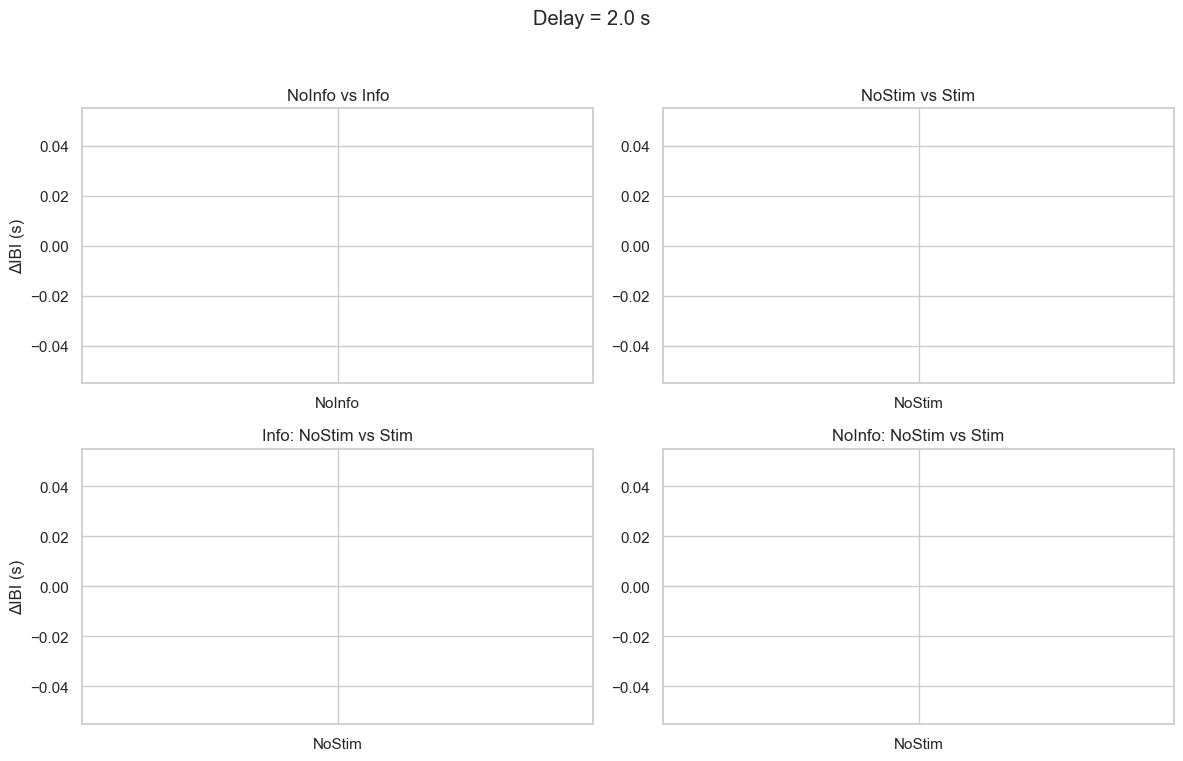

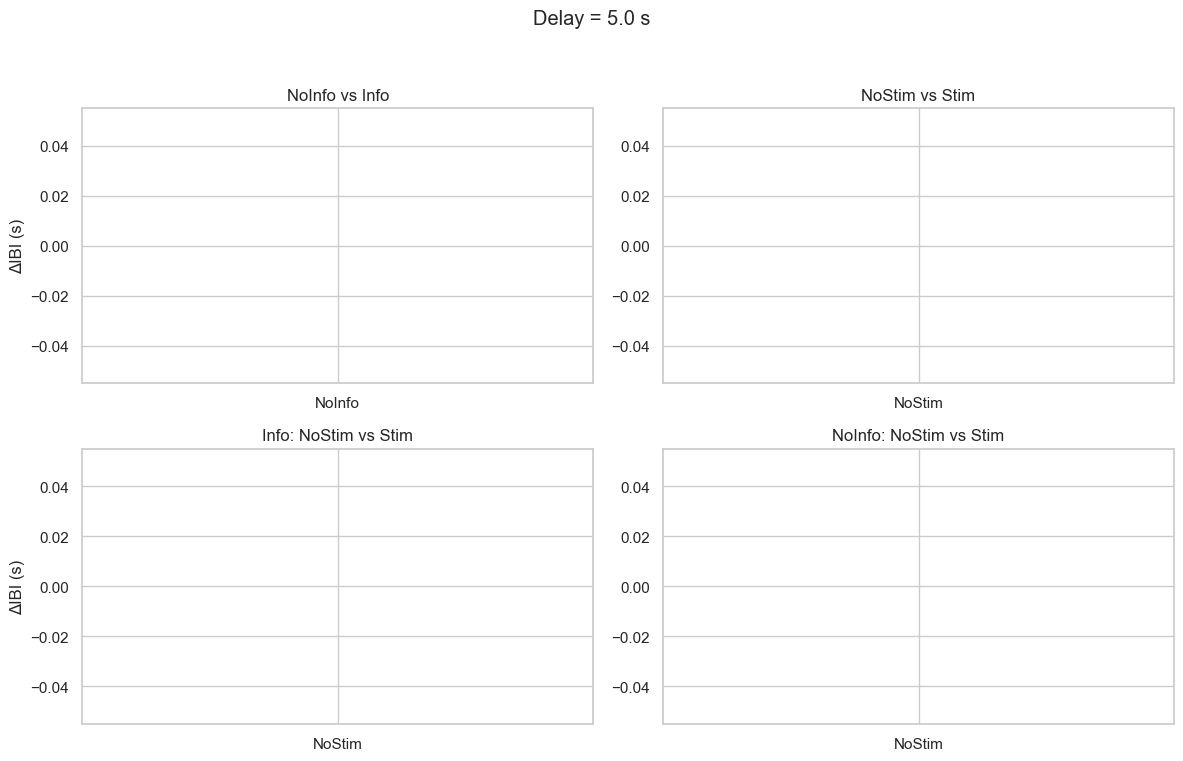

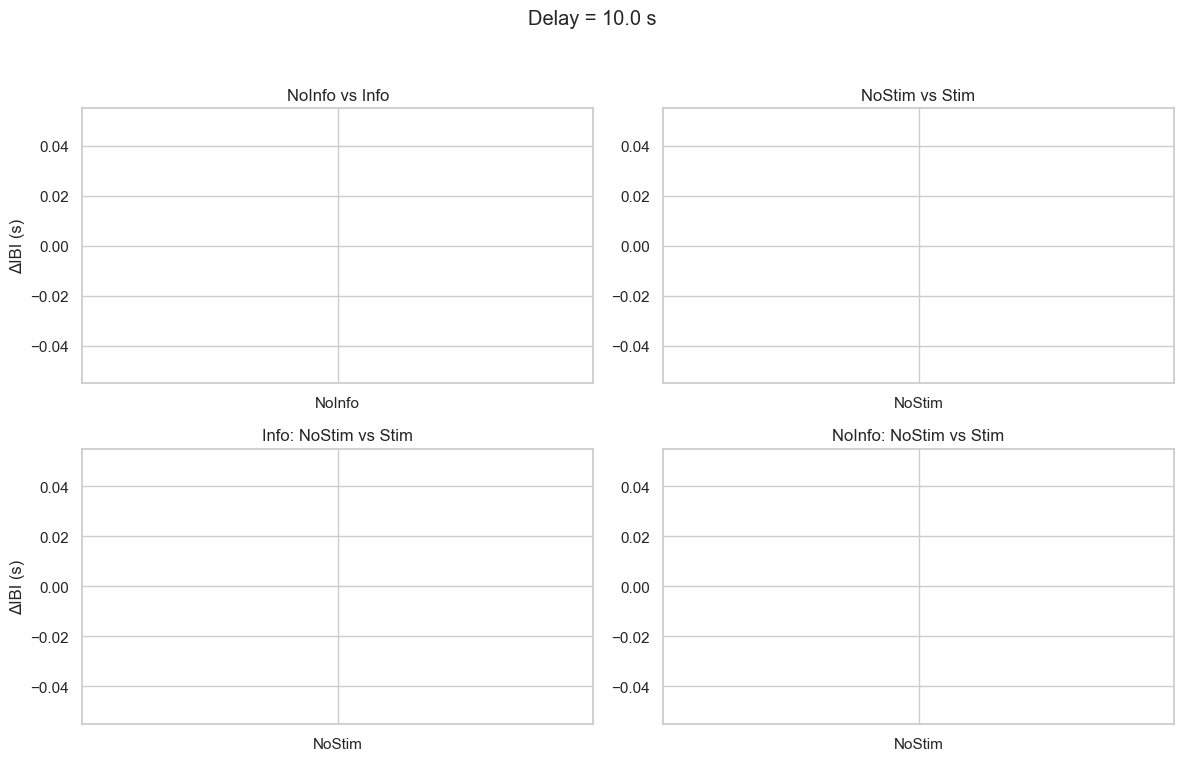

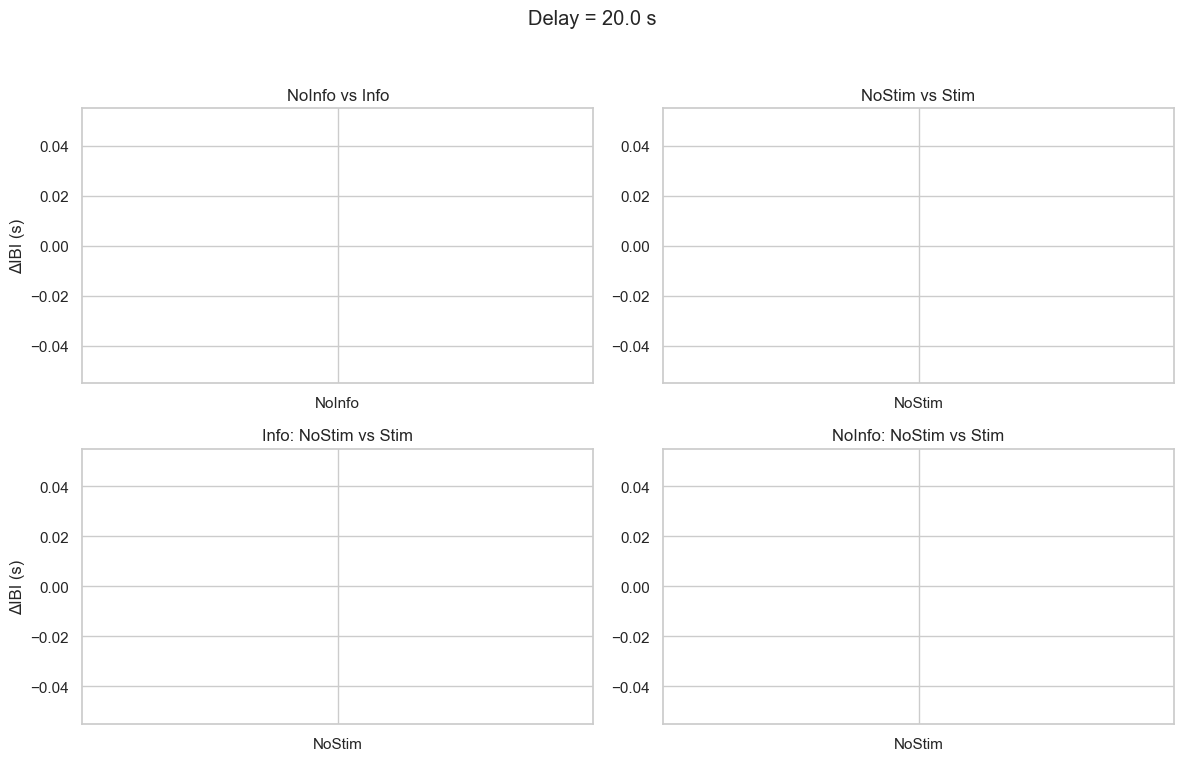

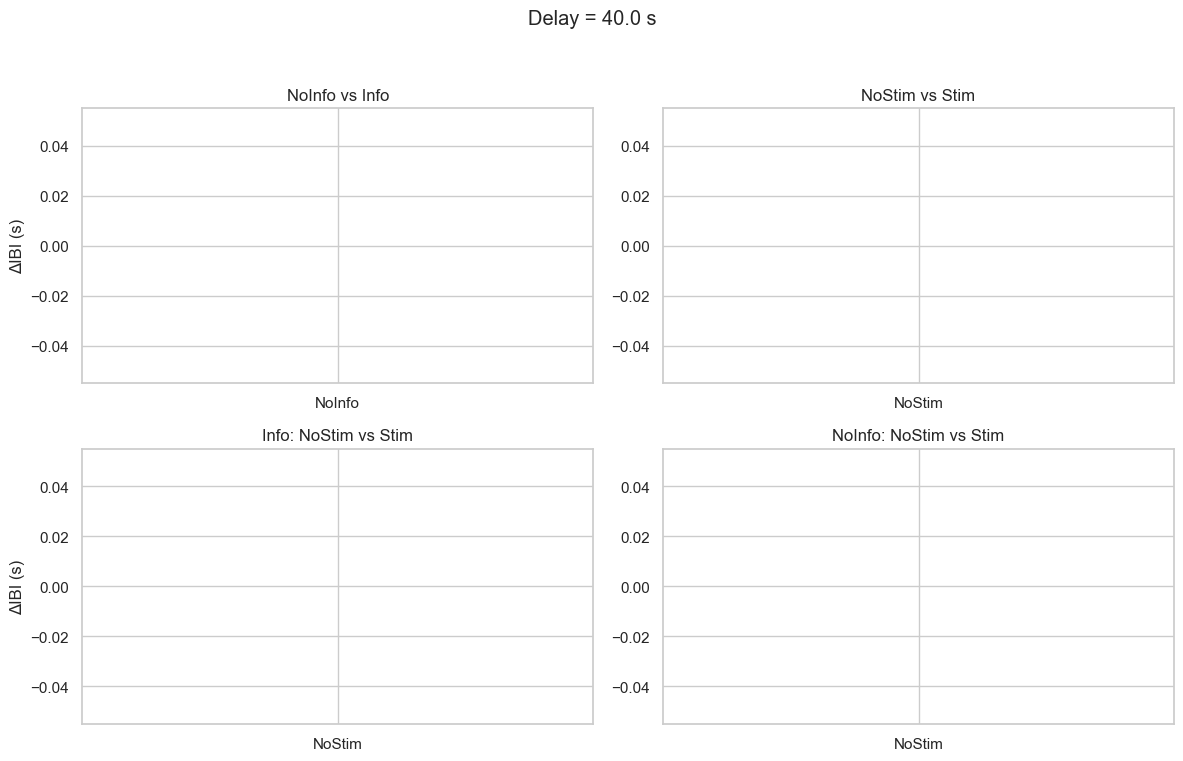

In [97]:
plot_conditions_by_delay(interval_df)


In [55]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks
import matplotlib.pyplot as plt
import seaborn as sns

# ————— 1) Build peaks DataFrame —————
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, find_peaks

def build_peaks_df(df, sfreq=1000):
    """
    Filters ECG, detects R‑peaks, computes IBIs, and pulls in only the two
    onset columns (infoOnset & stimOnset) from the trial‑level metadata.
    Returns a DataFrame with exactly these columns:
      partNum, session, trials,
      delay, stimInfo, stimNoInfo, scream, noScream,
      infoOnset, stimOnset,
      ibi
    """
    # 1) copy & filter
    df = df.copy()
    b, a = butter(2, [5/(sfreq/2), 25/(sfreq/2)], btype='band')
    df['pEKG'] = filtfilt(b, a, df['EKG'].values)

    # 2) detect R‑peaks
    idxs, _ = find_peaks(df['pEKG'], distance=int(0.4*sfreq), prominence=0.3)
    df['peak'] = False
    df.loc[idxs, 'peak'] = True
    df['peak_time'] = np.where(df['peak'], df['time'], np.nan)

    # 3) build peaks_df & compute IBIs
    peaks_df = df[df['peak']].copy()
    peaks_df['ibi'] = (
        peaks_df
        .groupby(['partNum','session','trials'])['peak_time']
        .diff()
    )

    # 4) extract just the onset times per (part, session, trial)
    events = []
    for (part, session, trial), sub in df.groupby(['partNum','session','trials']):
        # info‑cue onset
        if sub['stimInfoOnset'].eq(1).any():
            infoOnsetTime = sub.loc[sub['stimInfoOnset']==1, 'time'].iloc[0]
        elif sub['stimNoInfoOnset'].eq(1).any():
            infoOnsetTime = sub.loc[sub['stimNoInfoOnset']==1, 'time'].iloc[0]
        else:
            infoOnsetTime = np.nan

        # stimulus onset
        if sub['screamOnset'].eq(1).any():
            stimOnsetTime = sub.loc[sub['screamOnset']==1, 'time'].iloc[0]
        elif sub['noScreamOnset'].eq(1).any():
            stimOnsetTime = sub.loc[sub['noScreamOnset']==1, 'time'].iloc[0]
        else:
            stimOnsetTime = np.nan

        events.append({
            'partNum':   part,
            'session':   session,
            'trials':    trial,
            'infoOnsetTime': infoOnsetTime,
            'stimOnsetTime': stimOnsetTime
        })

    events_onsets = (
        pd.DataFrame(events)
        [['partNum','session','trials','infoOnset','stimOnsetTime']]
    )

    # 5) merge only the two onset columns (no _x/_y)
    peaks_df = peaks_df.merge(
        events_onsets,
        on=['partNum','session','trials'],
        how='left'
    )

    # 6) rename delay_time → delay, then select exactly the columns you want
    peaks_df = peaks_df.rename(columns={'delay_time': 'delay'})
    cols = [
        'partNum','session','trials',
        'delay','stimInfo','stimNoInfo','scream','noScream',
        'infoOnsetTime','stimOnsetTime',
        'ibi'
    ]
    return peaks_df[cols]


# ————— 2) Compute baseline per participant/session —————
def compute_baseline(peaks):
    """
    Baseline IBI is the average IBI in the pre_window before info cue,
    only for trials where trials == 1, and ignoring any NaN IBIs.
    """
    # 1) keep only trial 1 rows
    df1 = peaks[peaks['trials'] == 1]
    # 2) drop any rows where ibi is NaN
    df1 = df1.dropna(subset=['ibi'])
    # 3) group and take the mean (skipna=True is the default)
    baseline = (
        df1
        .groupby(['partNum', 'session'])['ibi']
        .mean()
        .reset_index(name='baseline')
    )
    return baseline


# ————— 3) Compute normalized IBIs per trial —————
def compute_interval_ibi(peaks_df, baseline_df, pre_window=2.0, post_window=2.0):
    """
    For each trial, average IBIs from infoOnset-pre_window to stimOnset+post_window,
    subtract baseline. Returns DataFrame per trial with normalized IBI.
    """
    records = []
    group_cols = ['partNum','session','trials','delay',
                  'stimInfo','stimNoInfo','scream','noScream']
    for key, grp in peaks_df.groupby(group_cols):
        part, session, trial, delay, info_flag, noinfo_flag, scream_flag, noscream_flag = key
        info_on = grp['infoOnset'].iloc[0]
        stim_on = grp['stimOnset'].iloc[0]
        start   = info_on - pre_window
        end     = stim_on + post_window
        mask    = (grp['peak_time']>=start) & (grp['peak_time']<=end)
        mean_ibi = grp.loc[mask, 'ibi'].mean()
        base_row = baseline_df[(baseline_df['partNum']==part)&(baseline_df['session']==session)]
        base      = base_row['baseline'].iloc[0] if not base_row.empty else np.nan
        norm_ibi  = mean_ibi - base
        records.append({
            'delay':      delay,
            'stimInfo':   info_flag,
            'stimNoInfo': noinfo_flag,
            'scream':     scream_flag,
            'noScream':   noscream_flag,
            'mean_ibi':   mean_ibi,
            'norm_ibi':   norm_ibi
        })
    return pd.DataFrame(records)

# ————— 4) Plot comparisons by delay —————
def plot_conditions_by_delay(interval_df):
    """
    For each delay, show 4 bar plots comparing:
      (1) NoInfo vs Info
      (2) NoScream vs Scream
      (3) Info trials: NoScream vs Scream
      (4) NoInfo trials: NoScream vs Scream
    """
    sns.set_style('whitegrid')
    for d in sorted(interval_df['delay'].dropna().unique()):
        df_d = interval_df[interval_df['delay']==d]
        fig, axes = plt.subplots(2,2,figsize=(12,8))
        # (1)
        df1 = df_d.groupby('stimInfo')['norm_ibi'].mean().reindex([0,1]).reset_index()
        axes[0,0].bar(['NoInfo','Info'], df1['norm_ibi'], color=['gray','skyblue'])
        axes[0,0].set_title('NoInfo vs Info')
        axes[0,0].set_ylabel('ΔIBI (s)')
        # (2)
        df2 = df_d.groupby('noScream')['norm_ibi'].mean().reindex([0,1]).reset_index()
        axes[0,1].bar(['Scream','NoScream'], df2['norm_ibi'], color=['coral','gray'])
        axes[0,1].set_title('NoScream vs Scream')
        # (3)
        df3 = df_d[df_d['stimInfo']==1].groupby('noScream')['norm_ibi']\
                                .mean().reindex([0,1]).reset_index()
        axes[1,0].bar(['Scream','NoScream'], df3['norm_ibi'], color=['blue','lightgray'])
        axes[1,0].set_title('Info: NoScream vs Scream')
        axes[1,0].set_ylabel('ΔIBI (s)')
        # (4)
        df4 = df_d[df_d['stimInfo']==0].groupby('noScream')['norm_ibi']\
                                .mean().reindex([0,1]).reset_index()
        axes[1,1].bar(['Scream','NoScream'], df4['norm_ibi'], color=['red','lightgray'])
        axes[1,1].set_title('NoInfo: NoScream vs Scream')
        plt.suptitle(f'Delay = {d} s')
        plt.tight_layout(rect=[0,0.03,1,0.95])
        plt.show()

# === Full pipeline example ===
# mergedDFClean = pd.read_csv('mergedPhysioAndBehav_Jan2025.csv')
# peaks_df     = build_peaks_df(mergedDFClean)
# baseline_df  = compute_baseline(peaks_df)
# interval_df  = compute_interval_ibi(peaks_df, baseline_df)
# plot_conditions_by_delay(interval_df)


In [56]:
peaks_df     = build_peaks_df(mergedDFClean)

# interval_df  = compute_interval_ibi(peaks_df, baseline_df)
# plot_conditions_by_delay(interval_df)


KeyError: "['infoOnset'] not in index"

In [23]:
peaks_df.columns

Index(['PART_x', 'EKG', 'EDA', 'startBlock', 'startTrial', 'infoChoice',
       'stimInfo_x', 'stimNoInfo_x', 'scream_x', 'noScream_x', 'endTrial',
       'startTrialOnset', 'screamOnset', 'noScreamOnset', 'infoChoiceOnset',
       'stimInfoOnset', 'stimNoInfoOnset', 'startBlockOnset', 'timePart',
       'time', 'trials', 'zEDA', 'delays', 'delaysRaw', 'session', 'partNum',
       'PART_y', 'delay_time', 'choice_keys', 'prob', 'screamOn', 'infoOn',
       'filename', 'pEKG', 'peak', 'peak_time', 'ibi', 'delay', 'stimInfo_y',
       'stimNoInfo_y', 'scream_y', 'noScream_y', 'infoOnset', 'stimOnset'],
      dtype='object')

In [36]:
peaks_df.columns

Index(['PART_x', 'EKG', 'EDA', 'startBlock', 'startTrial', 'infoChoice',
       'stimInfo_x', 'stimNoInfo_x', 'scream_x', 'noScream_x', 'endTrial',
       'startTrialOnset', 'screamOnset', 'noScreamOnset', 'infoChoiceOnset',
       'stimInfoOnset', 'stimNoInfoOnset', 'startBlockOnset', 'timePart',
       'time', 'trials', 'zEDA', 'delays', 'delaysRaw', 'session', 'partNum',
       'PART_y', 'delay_time', 'choice_keys', 'prob', 'screamOn', 'infoOn',
       'filename', 'pEKG', 'peak', 'peak_time', 'ibi', 'delay', 'stimInfo_y',
       'stimNoInfo_y', 'scream_y', 'noScream_y', 'infoOnset', 'stimOnset'],
      dtype='object')

In [42]:
baseline_df = compute_baseline(peaks_df)

In [43]:
baseline_df

,partNum,session,baseline
0,44,0,4.340000
1,44,1,5.555000
2,44,2,5.093333
3,44,3,5.960000
4,53,0,4.908000
...,...,...,...
95,112,4,12.300000
96,119,1,3.320000
97,130,0,157.013636
98,130,2,5.463333


In [44]:
interval_df  = compute_interval_ibi(peaks_df, baseline_df)

KeyError: 'stimInfo'